# The Transient Universe II


1. Fit the same model from before with the same priors, but this time use nested sampling.
   Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it). 
An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlie
2. Another possible model that may explain the data is a Gaussian profile described by:
   $$ y = b+Aexp[-(t-t_0)^2/2\sigma_w^2] $$
   Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)
3. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.. 

In [1]:
import dynesty
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from dynesty import plotting as dyplot

In [12]:
def burst(t, theta):
    A, b, t_0, alpha = theta
    return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))

def gaussian(t, theta):
    A, b, t_0, sigma = theta
    return b+A*np.exp(-(((t-t_0)/sigma)**2 )/2)

def loglike(theta, t, f, err_f, model):
    if (model == 'burst'):
        f_model = burst(t, theta)
    elif (model == 'gaussian'):         # I'm already defining the prior and the likelihood so that they'll work also for the gaussian model later.
        f_model = gaussian(t, theta)

    return -0.5 * np.sum((f-f_model)**2/(err_f**2))

# Define our uniform prior.
def ptform(u, model):
    t0min, t0max = 0, 100
    Amin, Amax=0, 50
    bmin, bmax=0, 50
    alphamin, alphamax=np.exp(-5), np.exp(5)
    sigmaWmin, sigmaWmax=np.exp(-2), np.exp(3)
    
    A = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    b = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    t_0 = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])

    if(model=='burst'):   
        alpha = scipy.stats.loguniform.ppf(u[3], alphamin, alphamax)
        return A, b, t_0, alpha

    if(model=='gaussian'):
        sigma = scipy.stats.loguniform.ppf(u[3], sigmaWmin, sigmaWmax)
        return A, b, t_0, sigma

    

In [3]:
N = 24
data = np.load("transient.npy")
times = data[:, 0]
fluxes = data[:, 1]
e_fluxes = data[:, 2]

ndim = 4

In [19]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[times, fluxes, e_fluxes, 'burst'], ptform_args=['burst'])
sampler.run_nested()
results = sampler.results

C:\Users\ISAFA\AppData\Local\Temp\ipykernel_15212\694888481.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_15212\694888481.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))
1649it [01:51,  2.24it/s, bound: 0 | nc: 86 | ncall: 16518 | eff(%):  9.983 | loglstar:   -inf < -189.426 <    inf | logz: -197.819 +/-  0.120 | dlogz: 121.969 >  0.509]   C:\Users\ISAFA\AppData\Local\Temp\ipykernel_15212\694888481.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))
1653it [01:52,  3.65it/s, bound: 1 | nc: 15 | ncall: 16544 | eff(%):  9.992 | loglstar:   -inf < -187.831 <    inf | logz: -196.366 +/-  0.122 | dlogz: 120.563 >  0.509]C:\Users\ISAFA\AppData\Local\Temp\ipykernel_15212\694888481.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b+A*n

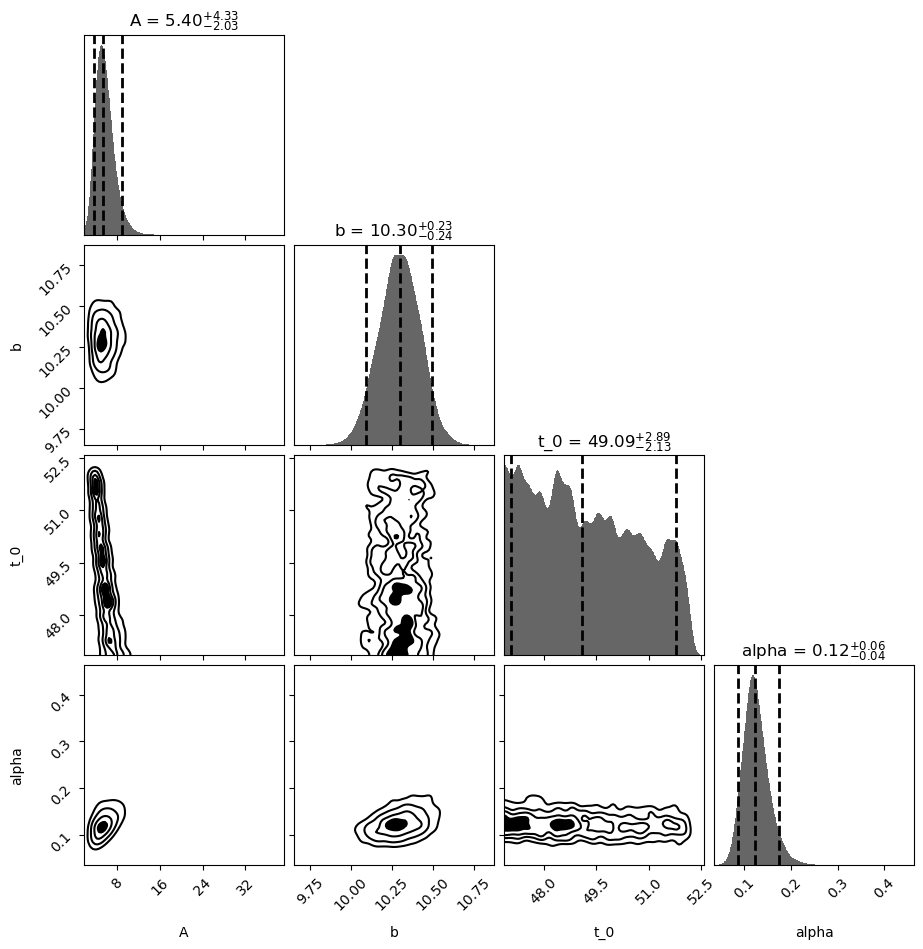

In [58]:
cfig, caxes = dyplot.cornerplot(results, show_titles = True, labels = ['A', 'b', 't_0', 'alpha'], quantiles=[0.05, 0.5, 0.95])

In [14]:
sampler2 = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[times, fluxes, e_fluxes, 'gaussian'], ptform_args=['gaussian'])
sampler2.run_nested()
results2 = sampler2.results

8046it [14:44,  9.10it/s, +500 | bound: 144 | nc: 1 | ncall: 124977 | eff(%):  6.866 | loglstar:   -inf < -52.480 <    inf | logz: -67.820 +/-  0.174 | dlogz:  0.001 >  0.509]


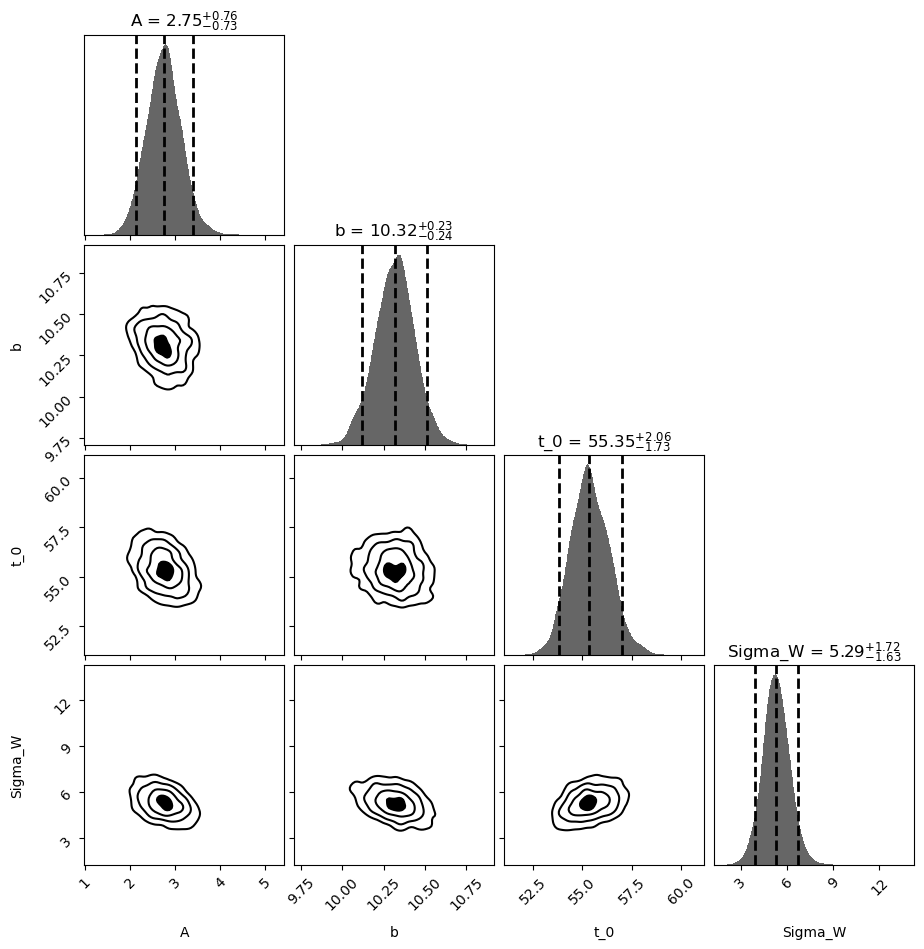

In [15]:
cfig, caxes = dyplot.cornerplot(results2, show_titles = True, labels = ['A', 'b', 't_0', 'Sigma_W'], quantiles=[0.05, 0.5, 0.95])

In [24]:
evidence1 = results.logz[-1] 
print("Bayesian evidence for burst model", np.exp(evidence1))

evidence2 = results2.logz[-1] 
print("Bayesian evidence for gaussian model", np.exp(evidence2))

#Bayesian factor
B = np.exp(evidence1)/np.exp(evidence2)
lnB = np.log(B)
print('The Bayes factor between the two models is B = %.2f' % B)
print('The ln(B) between the two models is B= %.2f' % lnB)

Bayesian evidence for burst model 3.59695273344166e-28
Bayesian evidence for gaussian model 3.5182438093465756e-30
The Bayes factor between the two models is B = 102.24
The ln(B) between the two models is B= 4.63


In Jeffrey scale this means that we have a strong evidence in favour of the burst model
